# Initialization

In [1]:
import numpy as np
from pprint import pprint
from copy import deepcopy

from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor
#from laboneq.contrib.example_helpers.generate_device_setup import generate_device_setup
from laboneq.dsl.device import DeviceSetup




descriptor = generate_descriptor(
    #pqsc=[""], # 장비 여러개 사용시
    shfqc_6=["DEV12576"],
    number_data_qubits=5,
    multiplex=True,
    number_multiplex=5,
    include_cr_lines=True,
    include_ef_lines=True,
    get_zsync=False,  # Only set to True when using real device
    save = True,
    filename="BF7_KRISS",
    ip_address="10.172.11.217"
)


#descriptor
setup = DeviceSetup.from_descriptor(yaml_text=descriptor, server_host="10.172.11.217")
#setup
setup.instruments[0].device_options = 'SHFQC/PLUS/QC6CH'
#setup.instruments

In [2]:
from laboneq.simple import Session
session = Session(setup)
session.connect(ignore_version_mismatch=True, do_emulation=False)
#session.disconnect()

[2025.10.16 21:21:48.940] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /home/kriss/JSAHN/qubit-experiment/examples/laboneq_output/log
[2025.10.16 21:21:48.941] INFO    VERSION: laboneq 2.61.0
[2025.10.16 21:21:48.942] INFO    Connecting to data server at 10.172.11.217:8004
[2025.10.16 21:21:48.951] INFO    Connected to Zurich Instruments LabOne Data Server version 25.07.0.507 at 10.172.11.217:8004
[2025.10.16 21:21:48.978] INFO    Configuring the device setup
[2025.10.16 21:21:48.987] INFO    The device setup is configured


In [3]:
from qpu_types.transmon import TransmonQubit, TransmonQubitParameters
from helper import load_qubit_parameters, save_qubit_parameters
from operations import TransmonOperations
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform



_loaded_qubits = load_qubit_parameters(filename="latest") 
qubits = list(_loaded_qubits.values())

#qubits = TransmonQubit.from_device_setup(setup) # Also can be done with load_qubit_parameters 




qpu = QPU(quantum_elements=qubits, quantum_operations=TransmonOperations())
#quantum_platform = QuantumPlatform(setup=setup, qpu=qpu)

# qpu.topology.add_edge("bus", "q16", "q17")
# qpu.topology.add_edge("bus", "q17", "q18")
# qpu.topology.add_edge("bus", "q18", "q19")
# qpu.topology.plot()




from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store") 
folder_store.activate()
#folder_store.deactivate()
workflow.logbook.LoggingStore().activate()
#workflow.logbook.LogbookStore().deactivate()


BF 7

In [4]:
#0 : 15 , 1 : 16 , 2 : 17, 3 : 18, 4 : 19
# for q in qubits:
#     #q.parameters.ge_drive_pulse["sigma"] = 0.25
#     q.parameters.readout_amplitude = 1.0
#     q.parameters.reset_delay_length = 20e-6

#     q.parameters.readout_range_out = -25
#     q.parameters.readout_range_in = 0
#     q.parameters.drive_range = -5

#     q.parameters.readout_lo_frequency = 7.0e9
#     q.parameters.drive_lo_frequency = 4.8e9

#     q.parameters.spectroscopy_length = 10e-6

#     q.parameters.ge_drive_length =64e-9

#     q.parameters.reset_delay_length = 60e-6*5


for q in qubits:
    q.parameters.readout_integration_delay = 200e-9
    q.parameters.reset_delay_length = 50e-6*5



# qubits[2].parameters.resonance_frequency_ge = 4.716e9 #Q17
# qubits[3].parameters.resonance_frequency_ge = 4.664e9 #Q18
# qubits[4].parameters.resonance_frequency_ge = 4.779e9 #Q19

# qubits[2].parameters.readout_resonator_frequency = 6.922557e9 #R17
# qubits[3].parameters.readout_resonator_frequency = 6.8433e9 #R18
# qubits[4].parameters.readout_resonator_frequency = 6.7739e9 #R19

# for idx, readout_amp in enumerate([1.0,1.0,1.0,1.0,1.0]):
#     qubits[idx].parameters.readout_amplitude = readout_amp



In [5]:
# for idx, readout_amp in enumerate([0.4,0.4,0.4,0.4,0.4]):
#     qubits[idx].parameters.readout_amplitude = readout_amp


# 1. Spectroscopy

In [ ]:
from helper import adjust_amplitude_for_output_range, calculate_power
adjust_amplitude_for_output_range(initial_output_dbm=0, initial_amplitude= 0.002, new_output_dbm=-5)
calculate_power(output_dbm=0, amplitude=0.001,attenuation=[])

### 1.1 Resonator spectroscopy with amplitude sweep

STRATEGY
1. CW spectroscpy for wide range scan
    * CW spectroscopy can be done for wide range scan 
    * amplitude, frequency 2D sweep 을 통해  power에 따른 broadening 및 SNR 경향 관찰
    * $\Delta F$ : frequency span,  $\Delta f_r$
    * Pick $\Delta F / \Delta f_r$ 1~2

In [ ]:
from experiments import resonator_spectroscopy_amplitude


####################################################################################
q=qubits[4]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temp_pars.readout_amplitude = 1.0
temporary_parameters[q.uid] = temp_pars
pprint(q.readout_parameters())
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
frequencies = q.parameters.readout_resonator_frequency + np.linspace(-15e6,15e6,5001)
amplitudes = np.linspace(0.0, 0.5, 21)
#####################################################################################
options = resonator_spectroscopy_amplitude.experiment_workflow.options()
#workflow.show_fields(options)
options.update(False)
options.use_cw(True)
options.do_analysis(True)
######################################################################################
# Build and run resonator_spectroscopy_amplitude wormflow
res_spec_amp = resonator_spectroscopy_amplitude.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    frequencies=frequencies,
    amplitudes=amplitudes,
    options=options
)
res_spec_amp_result=res_spec_amp.run()


### 1.2 Resonator Spectroscopy
* CW not recommended 

In [ ]:
from experiments import resonator_spectroscopy

####################################################################################
q=qubits[2]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temp_pars.readout_amplitude = 0.4
temporary_parameters[q.uid] = temp_pars
#######################################################################################
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
frequencies = q.parameters.readout_resonator_frequency + np.linspace(-5e6,5e6,10001)# for SCRES
#frequencies = q.parameters.readout_resonator_frequency + np.linspace(-5e6,5e6,1001)
#####################################################################################
options = resonator_spectroscopy.experiment_workflow.options()
#workflow.show_fields(options)
options.count(1024*3)
options.update(False)
options.use_cw(True) #qop.measure 
options.fit_complex_resonator(False)
options.fit_lorentzian(True)
######################################################################################
# Build and run resonator_spectroscopy_amplitude wormflow
res_spec = resonator_spectroscopy.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    frequencies=frequencies,
    options=options,
    temporary_parameters= temporary_parameters

)
res_spec_result = res_spec.run()
res_spec_analysis_result = res_spec_result.tasks["analysis_workflow"]
pprint(res_spec_analysis_result.output)

In [ ]:
res_spec_result.tasks["analysis_workflow"].tasks["fit_data"].output

In [ ]:
# res_spec_result.tasks["analysis_workflow"].tasks["plot_real_imaginary"].output

In [ ]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

#show_pulse_sheet(compiled_experiment=res_spec_result.tasks["compile_experiment"].output,name='test', interactive=True)
#plot_simulation(compiled_experiment=res_spec_result.tasks["compile_experiment"].output)

### 2.1 Qubit Spectroscopy with Amplitude Sweep
* Current qubit spectroscopy modules do not support CW 
* Recommended to use long enough spectroscopy drive (pulsed) to see steady state signals

In [ ]:
from experiments import qubit_spectroscopy_amplitude
####################################################################################
q=qubits[2]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars
###################################################################################
frequencies = q.parameters.resonance_frequency_ef + np.linspace(-2e6, 2e6, 101)
amplitudes = np.linspace(0.01, 0.002, 11)
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")

pprint(q.readout_parameters())
pprint(q.spectroscopy_parameters())
################################################################
options = qubit_spectroscopy_amplitude.experiment_workflow.options()
options.update(False)
# workflow.show_fields(options)
###################################################################
qubit_spec_amp = qubit_spectroscopy_amplitude.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    frequencies=frequencies,
    amplitudes=amplitudes,
    options=options,
    temporary_parameters=temporary_parameters
)

qubit_spec_amp_result = qubit_spec_amp.run()
qubit_spec_amp_result

In [ ]:
qubits[2].parameters.readout_resonator_frequency

### 2.2 Qubit Spectroscopy 


In [ ]:
from experiments import qubit_spectroscopy


####################################################################################
q=qubits[2]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temp_pars.drive_range = -5
#temp_pars.drive_lo_frequency = 4.4e9
temp_pars.spectroscopy_amplitude = 0.2#0.002 with 10us can see q17  0.2 with 1us can see two photon for q17
temp_pars.spectroscopy_length = 1.0e-6
temp_pars.readout_amplitude = 0.4
temp_pars.readout_length = 1.6e-6
temp_pars.readout_integration_length = 1.8e-6
#temp_pars.readout_resonator_frequency = 6.921e9
temporary_parameters[q.uid] = temp_pars
###############################################################

#frequencies = q.parameters.resonance_frequency_ge + np.linspace(-1e6, 1e6, 201)
#frequencies = 4.426e9 + np.linspace(-5e6, 5e6, 501)
frequencies = 4.5702e9 + np.linspace(-5e6, 5e6, 201)
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
pprint(q.readout_parameters())
pprint(q.spectroscopy_parameters())
################################################################
options = qubit_spectroscopy.experiment_workflow.options()
options.update(False)
options.count(1024)
# workflow.show_fields(options)
###################################################################
qubit_spec = qubit_spectroscopy.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    frequencies=frequencies,
    options=options,
    temporary_parameters=temporary_parameters
)

qubit_spec_result = qubit_spec.run()
qubit_spec_result

In [ ]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

show_pulse_sheet(compiled_experiment=qubit_spec_result.tasks["compile_experiment"].output,name='test', interactive=True)
plot_simulation(compiled_experiment=qubit_spec_result.tasks["compile_experiment"].output)

In [ ]:
qubits[3].parameters.resonance_frequency_ge - 289e6 

In [ ]:
(qubits[3].parameters.resonance_frequency_ge - 4.5207e9)*2 /1e6

In [ ]:
qubits[2].parameters.resonance_frequency_ef = qubits[2].parameters.resonance_frequency_ge - 290e6

In [ ]:
qubits[3].parameters.ef_drive_length = 64e-9

In [ ]:
qubits[3].transition_parameters("ge")

# ef pulse spectroscopy

같은 펄스 세기면 ef Rabi 속도가$\sqrt{2}$배 빠름

In [27]:
from experiments import ef_spectroscopy

q=qubits[2]
temporary_parameters = {}

temp_pars =deepcopy(q.parameters)
temp_pars.drive_range = -5
temp_pars.drive_lo_frequency = 4.6e9
temp_pars.spectroscopy_length = 2.0e-6
temp_pars.spectroscopy_amplitude = 0.1
temp_pars.readout_amplitude = 0.4
temp_pars.readout_length = 0.8e-6
temp_pars.readout_integration_length = 1.0e-6
temp_pars.readout_resonator_frequency = 6.921e9 #q e 일때 res freq으로
temporary_parameters[q.uid] = temp_pars
#######################################################################
pprint(q.readout_parameters())
pprint(q.spectroscopy_parameters())
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = ef_spectroscopy.experiment_workflow.options()
options.update(False)
options.do_fitting(True)
options.count(1024)

#print(workflow.show_fields(options))

#frequencies = qubits[2].parameters.resonance_frequency_ef + np.linspace(-20e6,+20e6,501)
frequencies = 4.4245e9 + np.linspace(-10e6,+10e6,301)
###################################################################
gs= ef_spectroscopy.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    options=options,
    frequencies=frequencies,
    temporary_parameters=temporary_parameters
)

gs_result = gs.run()
gs_analysis_result = gs_result.tasks['analysis_workflow'].output
print(gs_analysis_result)

('measure',
 {'amplitude': 0.4,
  'length': 1e-06,
  'pulse': {'function': 'GaussianSquare',
            'risefall_sigma_ratio': 3.0,
            'sigma': 0.2}})
('drive',
 {'amplitude': 0.002,
  'length': 1e-05,
  'pulse': {'function': 'GaussianSquare',
            'risefall_sigma_ratio': 3.0,
            'sigma': 0.2}})
DRIVE range (dBm) : -5, READOUT range (dBm) : -25
[2025.10.16 21:55:39.053] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.16 21:55:39.054] INFO      Workflow 'ef_spectroscopy': execution started at 2025-10-16 12:55:39.053502Z  
[2025.10.16 21:55:39.054] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.16 21:55:39.064] INFO    Task 'temporary_qpu': started at 2025-10-16 12:55:39.063961Z
[2025.10.16 21:55:39.065] INFO    Task 'temporary_qpu': ended at 2025-10-16 12:55:39.065017Z
[2025.10.16 21:55:39.067] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2025

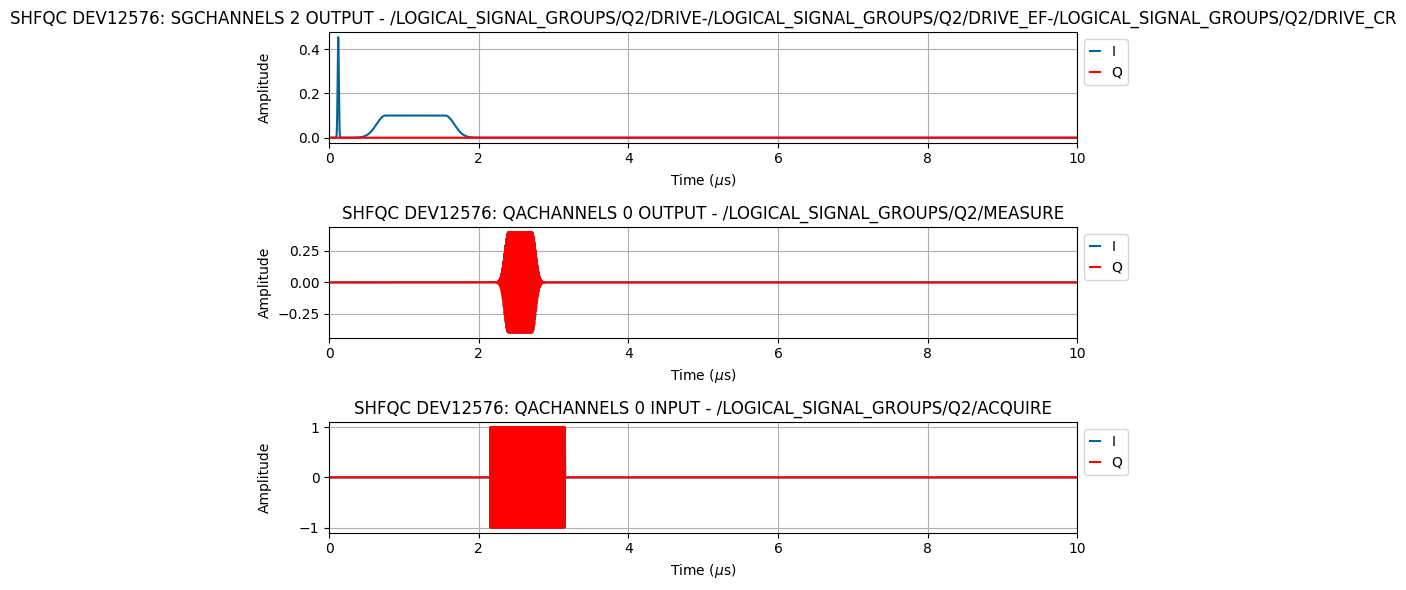

In [33]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

#show_pulse_sheet(compiled_experiment=gs_result.tasks["compile_experiment"].output,name='test', interactive=True)
plot_simulation(compiled_experiment=gs_result.tasks["compile_experiment"].output)

# qubit gate spectroscopy amplitude

In [ ]:
options = qubit_gate_spectroscopy_amplitude.experiment_workflow.options()
options.update(False)
workflow.show_fields(options)

In [ ]:
from experiments import qubit_gate_spectroscopy_amplitude
####################################################################################
q=qubits[2]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars
###################################################################################
frequencies = q.parameters.resonance_frequency_ef + np.linspace(-20e6, 20e6, 101)
amplitudes = np.linspace(0.01, 0.5, 21)
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")

pprint(q.readout_parameters())
pprint(q.spectroscopy_parameters())
################################################################
options = qubit_gate_spectroscopy_amplitude.experiment_workflow.options()
options.update(False)
options.spectroscopy_reset_delay(200e-6)
# workflow.show_fields(options)
###################################################################
qubit_gate_spec_amp = qubit_gate_spectroscopy_amplitude.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    frequencies=frequencies,
    amplitudes=amplitudes,
    options=options,
    temporary_parameters=temporary_parameters
)

qubit_gate_spec_amp_result = qubit_gate_spec_amp.run()
qubit_gate_spec_amp_result

In [ ]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

show_pulse_sheet(compiled_experiment=qubit_gate_spec_amp_result.tasks["compile_experiment"].output,name='test', interactive=True)
plot_simulation(compiled_experiment=qubit_gate_spec_amp_result.tasks["compile_experiment"].output)

# 2. Rabi

## 2.1 Rabi Amplitude 

In [35]:
qubits[2].transition_parameters("ef")

('drive_ef',
 {'amplitude_pi': 0.13043709645062712,
  'amplitude_pi2': 0.06647179851087102,
  'length': 1.28e-07,
  'pulse': {'function': 'drag', 'beta': 0, 'sigma': 0.25}})

In [36]:
from experiments import amplitude_rabi
####################################################################################
q=qubits[2]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
# temp_pars.ge_drive_amplitude_pi = 1.0

temp_pars.ef_drive_amplitude_pi = 1.0

temp_pars.readout_resonator_frequency = 6.92e9
temp_pars.readout_length = 0.8e-6
temp_pars.readout_integration_length =1.0e-6
temporary_parameters[q.uid] = temp_pars
###################################################################################
amplitudes = np.linspace(0.0, 0.5,301) 
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = amplitude_rabi.experiment_workflow.options()
options.update(True)
options.use_cal_traces(True)
options.cal_states("ef")
options.transition("ef")


#print(workflow.show_fields(options))

###################################################################
rabi_amp = amplitude_rabi.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    amplitudes=amplitudes,
    options=options
)

rabi_amp_result = rabi_amp.run()
#print(rabi_amp_result.tasks['analysis_workflow'].output)

DRIVE range (dBm) : -5, READOUT range (dBm) : -25
[2025.10.16 22:05:29.685] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.16 22:05:29.685] INFO      Workflow 'amplitude_rabi': execution started at 2025-10-16 13:05:29.684927Z   
[2025.10.16 22:05:29.685] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.16 22:05:29.694] INFO    Task 'temporary_qpu': started at 2025-10-16 13:05:29.694599Z
[2025.10.16 22:05:29.695] INFO    Task 'temporary_qpu': ended at 2025-10-16 13:05:29.695713Z
[2025.10.16 22:05:29.698] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2025-10-16 
[2025.10.16 22:05:29.698] INFO    13:05:29.697869Z
[2025.10.16 22:05:29.698] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2025-10-16 13:05:29.698774Z
[2025.10.16 22:05:29.699] INFO    Task 'create_experiment': started at 2025-10-16 13:05:29.699668Z
[2025.10.16 22:05:29.706] INFO    Task 'create_expe

In [ ]:
# from laboneq.simple import show_pulse_sheet
# from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

# show_pulse_sheet(compiled_experiment=rabi_amp_result.tasks["compile_experiment"].output,name='test', interactive=True)
# #plot_simulation(compiled_experiment=res_spec_result.tasks["compile_experiment"].output)

## 2.2 (optional) Rabi Amplitude Chevron 

In [ ]:
from experiments import amplitude_rabi_chevron

#######################################################################
q = qubits[2]
q.parameters.drive_range = 0
amplitudes = np.linspace(0,1.0,21)
frequencies = q.parameters.resonance_frequency_ge + np.linspace(-50e6, 50e6, 201)
pprint(q.transition_parameters())
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = amplitude_rabi_chevron.experiment_workflow.options()

#print(workflow.show_fields(options))

###################################################################
rabi_amp_chev = amplitude_rabi_chevron.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    frequencies=frequencies,
    amplitudes=amplitudes,
    options=options
)

rabi_amp_chev_result = rabi_amp_chev.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(rabi_amp_chev_result.tasks['analysis_workflow'].output)


## 2.3 Rabi Length
- Extracting effective Rabi Frequency $\Omega/ 2\pi$

이유는 모르겠으나 ef rabi length 비선형적임

In [ ]:
qubits[2].parameters.ef_drive_length 

In [ ]:
from experiments import time_rabi
#######################################################################
q = qubits[2]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)

temporary_parameters[q.uid] = temp_pars
lengths = np.linspace(128e-9, 256e-9, 21 ),
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = time_rabi.experiment_workflow.options()
options.update(False)
options.use_cal_traces(True)
#print(workflow.show_fields(options))

###################################################################
rabi_length = time_rabi.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    lengths=lengths[0].tolist(),
    options=options,
    temporary_parameters = temporary_parameters
)

rabi_length_result = rabi_length.run()
rabi_length_analysis_result = rabi_length_result.tasks['analysis_workflow']
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(rabi_length_result.tasks['analysis_workflow'].output)


In [ ]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

show_pulse_sheet(compiled_experiment=rabi_length_result.tasks["compile_experiment"].output,name='test', interactive=True)
plot_simulation(compiled_experiment=rabi_length_result.tasks["compile_experiment"].output)

In [ ]:
rabi_length_analysis_result.tasks['plot_population'].output['q2']

## 2.2 (optional) Rabi Length Chevron

In [ ]:
# from experiments import time_rabi_chevron
# #######################################################################
# q = qubits[2]

# frequencies = q.parameters.resonance_frequency_ge + np.linspace(-5e6, 5e6, 21)
# lengths = np.linspace(0.0, 240e-9, 21 ),
# print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
# #######################################################################
# options = time_rabi_chevron.experiment_workflow.options()
# #print(workflow.show_fields(options))

# ###################################################################
# rabi_length_chev = time_rabi_chevron.experiment_workflow(
#     session=session,
#     qpu=qpu,
#     qubits=q,
#     frequencies=frequencies,
#     lengths=lengths,
#     options=options
# )


# rabi_length_chev_result = rabi_length_chev.run()
# #qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
# print(rabi_length_chev_result.tasks['analysis_workflow'].output)


# 3. Ramsey

In [ ]:
qubits[2].parameters.resonance_frequency_ge

In [ ]:
from experiments import ramsey

q = qubits[2]
#######################################################################
delays = np.linspace(0,20e-6,301)
detunings = 0.4e6
pprint(q.readout_parameters())
#######################################################################
options = ramsey.experiment_workflow.options()
options.update(True)
options.count(1024)
options.use_cal_traces(True)
# Build and run Ramsey workflow (no explicit command table options required)
ramsey_wf = ramsey.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    delays=delays,
    detunings=detunings,
    options=options
)
ramsey_result = ramsey_wf.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(ramsey_result.tasks['analysis_workflow'].output)

# X180

In [37]:
from laboneq_applications.experiments import amplitude_fine
q = qubits[2]
temporary_parameters = q.parameters.copy()

#######################################################################
repetitions =np.arange(1,20) # Due to short T1, 20   
#######################################################################
options = amplitude_fine.experiment_workflow_x180.options()
options.update(True)
options.use_cal_traces(True)
#options.do_pca(False)

#print(workflow.show_fields(options))

###################################################################
error_amp = amplitude_fine.experiment_workflow_x180(
    session=session,
    qpu=qpu,
    qubits=q,
    repetitions=repetitions,
    temporary_parameters={q.uid : temporary_parameters},
    options=options
)

error_amp_result = error_amp.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(error_amp_result.tasks['analysis_workflow'].output)

[2025.10.16 22:06:48.326] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.16 22:06:48.326] INFO      Workflow 'experiment_workflow_x180': execution started at 2025-10-16          
[2025.10.16 22:06:48.326] INFO      13:06:48.326056Z                                                              
[2025.10.16 22:06:48.327] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.10.16 22:06:48.337] INFO    Task 'temporary_qpu': started at 2025-10-16 13:06:48.336801Z
[2025.10.16 22:06:48.337] INFO    Task 'temporary_qpu': ended at 2025-10-16 13:06:48.337726Z
[2025.10.16 22:06:48.339] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2025-10-16 
[2025.10.16 22:06:48.340] INFO    13:06:48.339772Z
[2025.10.16 22:06:48.340] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2025-10-16 13:06:48.340544Z
[2025.10.16 22:06:48.341] INFO    Task 'create_experiment': started at 2025-10-16 13:

# X90

In [ ]:
from laboneq_applications.experiments import amplitude_fine
q = qubits[4]
temporary_parameters = q.parameters.copy()

#######################################################################
repetitions =np.arange(1,30)
#######################################################################
options = amplitude_fine.experiment_workflow_x90.options()
options.update(False)
options.use_cal_traces(True)
#options.do_pca(False)

#print(workflow.show_fields(options))

###################################################################
error_amp = amplitude_fine.experiment_workflow_x90(
    session=session,
    qpu=qpu,
    qubits=q,
    repetitions=repetitions,
    temporary_parameters={q.uid : temporary_parameters},
    options=options
)

error_amp_result = error_amp.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(error_amp_result.tasks['analysis_workflow'].output)

# Basic Readout optimization
Here we optimize SNR via

* `readout_length`
* `readout-amplitude`

* `readout_integration_length`
* `readout_integration_delay`
* `readout_integration_weight`

In [ ]:
qubits[2].readout_integration_parameters()

In [ ]:
qubits[2].parameters = 

In [ ]:

from laboneq_applications.experiments import iq_blobs

#######################################################################
q = qubits[2]

temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temp_pars.readout_resonator_frequency = 6.92e9
# temp_pars.readout_length = 1.6e-6
# temp_pars.readout_integration_length = 1.8e-6
temporary_parameters[q.uid] = temp_pars
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = iq_blobs.experiment_workflow.options()

#print(workflow.show_fields(options))

###################################################################
iq = iq_blobs.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    options=options,
    states='gef',
    temporary_parameters=temporary_parameters
)

iq_result = iq.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(iq_result.tasks['analysis_workflow'].output)


In [ ]:
qubits[2].readout_parameters()

# Dispersive Shift
-todo 
dispersive shift 얻는부분 정확하게 만들어야함

$$
\chi \approx - \frac{g^2\alpha}{\Delta(\Delta+\alpha)}
$$

In [ ]:
(qubits[2].parameters.resonance_frequency_ge - 6.9220e9)/1e6

In [ ]:
def get_g(chi,detuning,alpha):
    g=np.sqrt(chi*np.abs(detuning*(detuning+alpha)/alpha))
    return g

get_g(0.7,-2205,-260)

In [ ]:
from experiments import dispersive_shift

#######################################################################
q = qubits[2]

print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = dispersive_shift.experiment_workflow.options()
options.update(False)
#print(workflow.show_fields(options))

###################################################################
dispersive = dispersive_shift.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    frequencies=q.parameters.readout_resonator_frequency + np.linspace(-5e6,5e6,101),
    options=options,
    states='ge'
)

dispersive_result = dispersive.run()
print(dispersive_result.tasks['analysis_workflow'].output)

In [ ]:
from experiments import time_traces

# RB

PanicException: cannot increment oscillator phase w/o command table

In [ ]:
from experiments import single_qubit_randomized_benchmarking

#######################################################################
q = qubits[2]

print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = single_qubit_randomized_benchmarking.experiment_workflow.options()

#print(workflow.show_fields(options))

###################################################################
single_rb = single_qubit_randomized_benchmarking.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    length_cliffords=[1,5,10,20,50],
    variations=1,
    seed=4698,
    #gate_map={"id":None, "sx":"x90", "x":"x180", "rz":"rz"},
    options=options
)

single_rb_result = single_rb.run()
print(single_rb_result.tasks['analysis_workflow'].output)

# Save Qubit Parameters

In [38]:
from helper import load_qubit_parameters, save_qubit_parameters
save_qubit_parameters(qubits={ qubit.uid : qubit for qubit in qubits}, save_folder="./qubit_parameters", filename="KRISS")

Qubit parameters stored as JSON in /home/kriss/JSAHN/qubit-experiment/examples/qubit_parameters/20251016-2208_KRISS.json
